# Dear difflib, What The F@&#! ?

## TL,DR:

Acording to difflib, the following strings: 'baaaaa', 'aaabaa' and 'aaaaba' share 5 caracters with 'aaaaaa', but 'aabaaa' share only 3 .... but only if the change is in the first half of the string.

In [1]:
import difflib
print sum(x.size for x in difflib.SequenceMatcher(None, '-aaaaa', 'aaaaaa').get_matching_blocks())
print sum(x.size for x in difflib.SequenceMatcher(None, 'a-aaaa', 'aaaaaa').get_matching_blocks())
print sum(x.size for x in difflib.SequenceMatcher(None, 'aa-aaa', 'aaaaaa').get_matching_blocks())
print sum(x.size for x in difflib.SequenceMatcher(None, 'aaa-aa', 'aaaaaa').get_matching_blocks())
print '- Control -'
print sum(x.size for x in difflib.SequenceMatcher(None, 'aaaaaa', 'aaaaaa').get_matching_blocks())


5
4
3
5
- Control -
6


It only get weirder and more fractal if you read the rest

## Context

A few weeks back I was in [EuroSciPy](http://euroscipy.org), where I had to dive a little deeper than usual into difflib.
Indead, one often requested feature in [IPython](http://ipython.org) is to be able to diff notebooks, so I started looking at how this can be done. Thanks to [@MinRK](http://github.com/minrk) for helping me figuring out the rest of this post and give me some nices ideas of graphs.

Naturaly I turned myself toward [difflib] :


> This module provides classes and functions for comparing sequences. It can be used for example, for comparing files, and can produce difference information in various formats, including HTML and context and unified diffs. For comparing directories and files, see also, the filecmp module.

[difflib]: http://docs.python.org/2/library/difflib.html

More especially, I am interested in [`SequenceMatcher`](http://docs.python.org/2/library/difflib.html#difflib.SequenceMatcher) which aims to be : 

> [...] a flexible class for comparing pairs of sequences of any type, so long as the sequence elements are hashable.

It is also explicitely state that generated diff might not be minimal, but might looks more  "human readable" than classical diff (emphasis mine). 

> The basic algorithm [..] is a little fancier than,[...] “gestalt pattern matching.” The idea is to find the longest contiguous matching subsequence that contains no “junk” elements [...]. The same idea is then applied recursively to the pieces of the sequences to the left and to the right of the matching subsequence. This **does not yield minimal edit sequences**, but does tend to yield matches that **“look right”** to people.


To do that, we need to define "junk" which are things you don't want the algorithme to match on. 
Let see a common example in python where when you add a function with a derorator, the decorator is often added to the "next" function.

In [2]:
s1 = """
@decorate
def fun1():
    return 1
    
@decorate
def fun3():
    return 3
"""

s2 = """
@decorate
def fun1():
    return 1
    
@decorate
def fun2():
    return 2
    
@decorate
def fun3():
    return 3
"""

Classical diff

In [3]:
import difflib
print ''.join(difflib.ndiff(s1.splitlines(1), s2.splitlines(1)))

  
  @decorate
  def fun1():
      return 1
      
  @decorate
+ def fun2():
+     return 2
+     
+ @decorate
  def fun3():
      return 3



Now we will tell it that blank line are junk:

In [4]:
blankline = lambda x:x.strip() ==''
print ''.join(difflib.ndiff(s1.splitlines(1), s2.splitlines(1), linejunk=blankline))

  
  @decorate
  def fun1():
      return 1
      
+ @decorate
+ def fun2():
+     return 2
+     
  @decorate
  def fun3():
      return 3



This is clearly better, as hunk do not have blank lines in the midlle, but more on sides.

## Where it gets weird

Things is, `SequenceMatcher` is also the method that help you get the proximity between two strings.
If the sequence you pass to `SequenceMatcher` is a string, it will try to match each caracters.

In [5]:
from difflib import SequenceMatcher

In [6]:
print SequenceMatcher('hello world','hello world').ratio()
print SequenceMatcher('xyz','abc').ratio()

0.0
0.0


Oh, sorry, you need to explicitelty, pass the `isjunk` function. Hopefully, it accepts `None`.

In [7]:
print SequenceMatcher(None, 'hello world','hello world').ratio()
print SequenceMatcher(None, 'xyz','abc').ratio()

1.0
0.0


Ok, that's better, it goes from 0.0 for completely different strings (nothing in common) to 1.0 for perfectly matching strings.

API is weird, but for compatibility we keep the old one... fine with me

let's try longer...

In [8]:
print SequenceMatcher(None, 'y'+'abc'*150,'x'+'abc'*150).ratio()

0.0


Still, don't pass it strings longer than 200 char, it automatically detect junk... Yes this is documented, but not obvisous.

In [9]:
print SequenceMatcher(None, 'y'+'abc'*150,'x'+'abc'*150, autojunk=False).ratio()

0.9977827051


So let's define a custom SequenceMatcher that make sens for the rest of the post, so that `isjunk`is `None` by default, and no `autojunk` for `n > 200`, and a simple `ratio(a, b)` method as a shortcut.

In [10]:
def MySequenceMatcher( seq1, seq2, isjunk=None, autojunk=False):
    return SequenceMatcher(isjunk, seq1, seq2, autojunk=autojunk)

def ratio(a,b):
    return MySequenceMatcher(a,b).ratio()

In [10]:
print ratio('abc','abc')
print ratio('abcd','abcf')


1.0
0.75


## Where it gets weirder

I'll probably won't go into how we found out the following, but for some reason `ratio(a,b)` was different from `ratio(reversed(a),reversed(b))`, that is to say `ratio('ab...yz','ab...yz') != ratio('zy...ba','zy...ba')` in some case. 

So let's look at what happend if we compare a string against itself, with only one modification, as a function as the position of the modification, that is to say the ratio of `aaaa...` vs `baaa...` vs `abaa...` vs `aaba...`

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

aaaaaaaaaa ...
aaaaaaaaaa ...
-aaaaaaaaa ...
a-aaaaaaaa ...
aa-aaaaaaa ...
aaa-aaaaaa ...
aaaa-aaaaa ...
aaaaa-aaaa ...
aaaaaa-aaa ...
aaaaaaa-aa ...
aaaaaaaa-a ...
..............


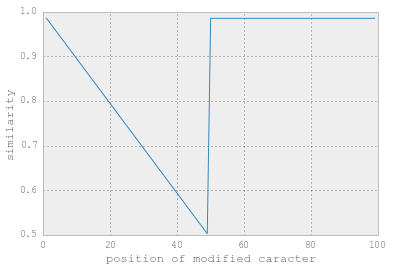

In [12]:
n = 100
step = 1
s1 = u'a'*n
r = lambda x : ratio(x, s1)

def modified(i):
    """ return the string s1, where the i-th is replaced by -"""
    return s1[:i-1]+u'-'+s1[i+1:]

xx = range(1, n, step)


print(s1[:10]),'...'
for i in range(10):
    print(modified(i)[:10]),'...'
print('..............')
distance = map( r, [modified(i) for i in xx])

plt.plot(xx, distance)
plt.ylabel('similarity')
plt.xlabel('position of modified caracter')

WWWHHHHAAAAAT ???

Hum..let's look with some other string, basically same as before, but with repeating sequence `ababab..`, `abcabcabcabc...`

In [13]:
import string

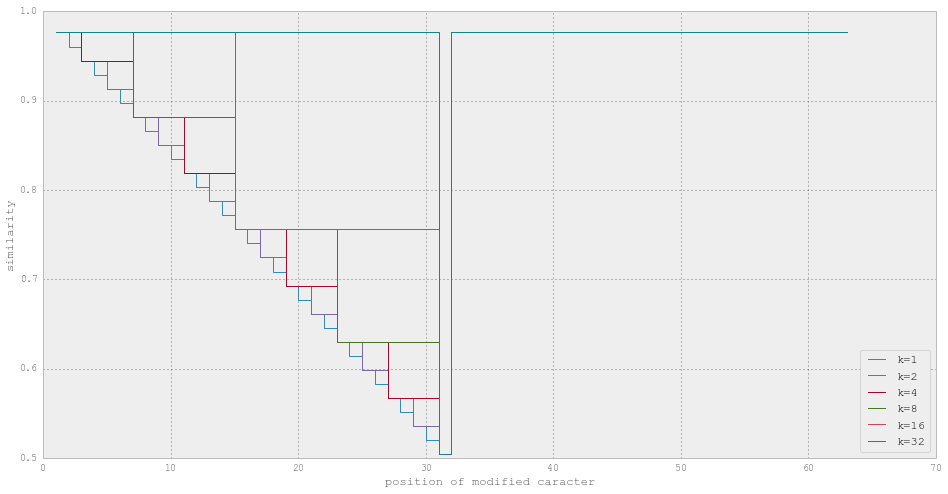

In [14]:
def test_rep(k=1, n=128):
    s1 = string.letters[:k]*int(n/k*2)
    s1 = s1[:n]
    r = lambda x : ratio(x, s1)
    
    def modified(i):
        """ return the string s1, where the i-th is replaced by -"""
        return s1[:i-1]+u'-'+s1[i+1:]
    
    xx = range(1, n, step)
    distance = map( r, [modified(i) for i in xx])
    return xx,distance

fig,ax = plt.subplots(1,1)
fig.set_figwidth(16)
fig.set_figheight(8)

for k in [1,2,4,8,16,32]:
    xx, distance = test_rep(k, n=64)
    plt.step(xx, distance, where='post', label='k={k}'.format(k=k))
    

plt.ylabel('similarity')
plt.xlabel('position of modified caracter')
plt.legend(loc=4)

(bottom of the graph is at 0.5, not 0.0)

Huummm... this definitively does not look at what I was expecting (mainly something constant), but looks more like a [Sierpinski triangle](http://en.wikipedia.org/wiki/Sierpinski_triangle) to me.

Bottom line, even if difflib make some pretty looking diff, I cannot trust it for giving me proximity of two sequences.

## Still Some good sides...

Anyway, I knew what [levenstein distance](http://en.wikipedia.org/wiki/Levenshtein_distance) was, but not really
what the efficient algorithme where. I played around a little bit with them, and recoded them in pure python.
I'll post the link soon, just time to clean things up im make them as pure python module. Below is how it looks like.

Thing is, as far as I can tell, libdiff stays an order of magnitude faster in some cases, as well as computes the matches at the same time.

In [15]:
def lcs_len3(Seq1 , Seq2):
    """ Compute the LCS len 2 sequences
    
    Do not calculate the matrix and try to be as efficient as possible 
    in storing only the minimal ammount of elelment in memory, mainly the previous
    matrix row + 1 element.
    """
    LL1 = len(Seq1)+1
    LL2 = len(Seq2)+1

    ## we will do the big loop over the longest sequence (L1)
    ## and store the previous row of the matrix (L2+1)
    if LL2 > LL1 : 
        Seq2, Seq1 = Seq1, Seq2
        LL2, LL1 = LL1, LL2

    
    previousrow = [0]*(LL2)
    cindex = 0

    for Seq1ii in Seq1:
        for jj in range(1,LL2):
            cindex = (cindex+1) % LL2

            if Seq1ii == Seq2[jj-1]:
                if jj == 1:
                    previousrow[cindex] = 1
                else :
                    previousrow[cindex]+=1
            if Seq1ii != Seq2[jj-1] :
                up = previousrow[(cindex+1) % LL2]
                
                if jj != 1 :
                    left = previousrow[(cindex-1) % LL2]
                    if left > up :
                        previousrow[cindex] = left
                        continue    
                previousrow[cindex] = up


    return previousrow[cindex]

In [16]:
import numpy as np
import difflib

In [17]:
def compare(s1,s2):
    m0 = difflib.SequenceMatcher(None, s1, s2, autojunk=False).get_matching_blocks()
    m1 = lcs_len3(s1,s2)
    a,b = sum([x.size for x in m0]),m1
    return a,b 

for k in range(10):
    s1 = np.random.randint(0,250, 100)
    s2 = np.random.randint(0,250, 100)
    a,b = compare(s1,s2)
    print 'random',u'√' if a == b else 'x',a,b
    a,b = compare(sorted(s1),sorted(s2))
    print 'sorted',u'√' if a == b else 'x',a,b
    

random x 4 8
sorted √ 23 23
random x 4 9
sorted √ 26 26
random x 6 10
sorted √ 25 25
random x 4 12
sorted √ 27 27
random x 5 7
sorted √ 27 27
random x 7 10
sorted √ 30 30
random x 6 13
sorted √ 33 33
random x 9 10
sorted √ 25 25
random x 2 7
sorted √ 28 28
random x 5 10
sorted √ 27 27


Except on the sorted case, SequenceMatcher from stdlib give the wrong matches length almost all the time (sometime it is right)

In [18]:
%timeit difflib.SequenceMatcher(None, s1, s2, autojunk=False).get_matching_blocks()
%timeit lcs_len3(s1,s2)
print '--------- sorted ----------'
s1.sort()
s2.sort()
%timeit difflib.SequenceMatcher(None, s1, s2, autojunk=False).get_matching_blocks()
%timeit lcs_len3(s1,s2)

1000 loops, best of 3: 402 µs per loop
100 loops, best of 3: 9.38 ms per loop
--------- sorted ----------
1000 loops, best of 3: 734 µs per loop
100 loops, best of 3: 9.33 ms per loop


On both sorted and unsorted arrays, SequenceMatcher is way faster (10 to 20 times) than I am, but wrong.

In [19]:
s1 = 'a'*251
i = 124
s2 = 'a'*(i)+'b'+'a'*(250-i)
%timeit MySequenceMatcher(s1, s2).get_matching_blocks()        
%timeit lcs_len3(s1,s2)

10 loops, best of 3: 26 ms per loop
10 loops, best of 3: 30.8 ms per loop


In [20]:
sum(x.size for x in MySequenceMatcher(s1, s2).get_matching_blocks())

126

But in the cases where `SequenceMatcher` is clearly wrong for the **optimal** sequence, we are around the same time to execute.

Not that I don't like current python libdiff, but I hope to be able to build a lower lever library (pure python of course) without any surprise behavior, on which maby one can rebuild the current libdiff and avoid to rely on [regular expression](http://hg.python.org/cpython/file/0872257752c2/Lib/difflib.py#l1371) to parse the output of another function. 

I'll be happy to get any tips to make it faster, of course it is not possible in all the cases but I'm sure we can figure it out.

---

As usual comments, typo and PRs welcommed on the [repo that host thoses notebooks](https://github.com/Carreau/posts/issues). I should probably learn how to use [Pelican](http://docs.getpelican.com/en/3.2/) now that it [support notebooks](https://github.com/getpelican/pelican-plugins/pull/21).

---

**Edit**:  At the request of some person, I opened a place to **[comment on this post](https://github.com/Carreau/posts/issues/2)** until I turn it into a real blogpost.